In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import lightkurve as lk

from ipywidgets import *
import pandas as pd

import utils
import starry
import numpy as np

starry.config.lazy = False
starry.config.quiet = True

In [71]:
def omega_sini(vsini, M, R):
    G_mks = 6.67e-11
    v_breakup = (G_mks*M/R)**(1/2)
    return vsini/v_breakup

## Defining orbital parameters for Wasp 33

First, we define orbital parameters from Wasp-33. These values are derived from Von Essen 2020 for the stellar and planetary parameters and from Borsa et al. 2021 for the projeted obliquity. 

In [392]:
G_mks = 6.67e-11
Msun = 1.989e+30
Rsun = 6.95700e8
M_star = 1.59
R_star = 1.561 #1.561
beta = 0.23
tpole = 7340

u1 = 0.246
u2 = 0.252
inc = 0
vsini = 86.4 #in km/s
omega = omega_sini(vsini*1000,M_star*Msun, R_star*Rsun)
omega_s = omega/(np.sin(np.radians(90-inc))) #should create a function converting vsini to omega*sini

In [393]:
rprs = 0.1087
period = 1.2198681 
inc_p = 88.01 #89.5
omega_p = 115
w = 0
t0 = 0
m_planet = 2.16 #planet mass in jupiter masses

## Finding the x, y, z positions of Wasp-33 using a spherical model (temporary hack)

Now, we create a starry System objet and plug in the above planetary parameters. For now, we model the star as a sphere (temporary hack since the oblate System class has no flux method yet). We then calculate the x y and z positions of the planets and plug these into the oblate model to find the real transit model. This will allow us to use the above orbital parameters, including the projected obliquity, to calculate a full model for the transit including the oblateness of the star. 

In [394]:
map33 = starry.Map(udeg=2, gdeg=4, oblate=False) #ydeg = 2*order_approx udeg=2
map33.omega=omega_s
map33.beta=beta
map33.wav=510
map33.tpole=tpole
map33[1] = u1
map33[2] = u2

star = starry.Primary(map33, m=M_star, r=R_star,prot=100000)
star.map.inc=90-inc

planet = starry.kepler.Secondary(map=starry.Map(lmax=2),
    m=m_planet*0.000954588,  # mass in solar masses
    r=rprs*star.r,  # radius in solar radii
    porb=period,  # orbital period in days
    inc=inc_p,
    Omega=omega_p,  # longitude of ascending node in degrees
    ecc=0.0,  # eccentricity
    w=w,  # longitude of pericenter in degrees
    t0=t0,  # time of transit in days
)

system = starry.System(star, planet)

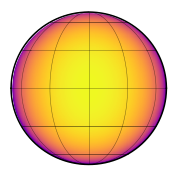

In [395]:
map_obl = starry.Map(udeg=2, gdeg=4, oblate=True) #ydeg = 2*order_approx udeg=2
map_obl.omega=omega_s
map_obl.beta=beta
map_obl.wav=510
map_obl.tpole=tpole
map_obl.f = utils.f(omega_s)
map_obl[1] = u1
map_obl[2] = u2
map_obl.inc=90-inc
map_obl.show()

In [396]:
system.flux(0.0); #hack to compile and create lightcurves faster

In [397]:
map_obl.inc

90.0

## Plotting the comparison of the spherical and oblate models:

In [ ]:
for inc_star in np.linspace(-20,20,10):
    map_obl.omega = omega_s/(np.sin(np.radians(90-inc_star)))
    map_obl.inc = -(90-inc_star)
    
    fig, (ax0, ax1) = plt.subplots(2, 1, figsize=[12, 10], gridspec_kw={'height_ratios': [3, 1]})

    padding = 0.2

    #read in Wasp-33 data, detrended for its delta scuti pulsations
    df = pd.read_csv("/Users/shashank/Documents/Python Files/wasp33TESS_clean.csv")
    lc = lk.LightCurve(time=df.time,flux=df.flux)
    wasp33_params = {'Epoch':2458792.63403-2457000, 'period':planet.porb,'tdur':0.1300}

    #fold the data for plotting
    fold = lc.fold(wasp33_params['period'],wasp33_params['Epoch'])

    #compute the lightcurve
    time = np.linspace(planet.porb-0.15, planet.porb+0.15, 500)
    x, y, z = system.position(time)
    _, xo = x
    _, yo = y
    _star, zo = z
    
    flux_star = map_obl.flux(xo=xo/star.r, yo=yo/star.r, ro=rprs)
    flux_sph, flux_planet = system.flux(time, total=False)

    ax0.set_xlim(planet.porb-padding,planet.porb+padding)
    ax0.scatter(fold.phase*wasp33_params['period']+wasp33_params['period'],fold.flux,s=1, label ='TESS data (pulsations subtracted)')

    ax0.plot(time, flux_star, c='black', label='Oblate star model')
    ax0.plot(time, flux_sph, c='red', label='Spherical star model')
    ax0.set_xlabel("time [days]")
    ax0.set_ylabel("system flux")
    ax0.legend()

    time_resids = df.time-wasp33_params['Epoch']
    x, y, z = system.position(time_resids)
    _, xo = x
    _, yo = y
    _star, zo = z
    
    flux_star = map_obl.flux(xo=xo/star.r, yo=yo/star.r, ro=rprs)
    resids = lk.LightCurve(time=df.time,flux=df.flux-flux_star)
    
    fold_resids = resids.fold(wasp33_params['period'],wasp33_params['Epoch'])
    sph_resid_flux, flux_planet = system.flux(time_resids, total=False)
    sph_resids = lk.LightCurve(time=df.time,flux=df.flux-sph_resid_flux)
    fold_resids_sph = sph_resids.fold(wasp33_params['period'],wasp33_params['Epoch'])

    
    
    ax1.set_xlim(planet.porb-padding,planet.porb+padding)
    ax1.set_ylim(-0.005,0.005)
    ax1.scatter(fold_resids.phase*wasp33_params['period']+wasp33_params['period'], fold_resids_sph.flux, s=2)
    ax1.plot(fold_resids_sph.phase*wasp33_params['period']+wasp33_params['period'], fold_resids_sph.flux-fold_resids.flux, c='black')
    ax1.plot(time_resids,[0 for i in df.flux],c='red')
    plt.suptitle(r"$i_{*} = "+str(inc_star)+r"$")
    plt.savefig("model tests/"+str(inc_star)+".png", dpi=500)

## Rudimentary least squares regression:

In [399]:
sph_resids = []
obl_resids = []

for inc_star in np.linspace(-15,30,100):
    map_obl.omega = omega_s/(np.sin(np.radians(90-inc_star)))
    map_obl.inc = -(90-inc_star)
    

    padding = 0.1

    #read in Wasp-33 data, detrended for its delta scuti pulsations
    df = pd.read_csv("/Users/shashank/Documents/Python Files/wasp33TESS_clean.csv")
    lc = lk.LightCurve(time=df.time,flux=df.flux)
    wasp33_params = {'Epoch':2458792.63403-2457000, 'period':planet.porb,'tdur':0.1300}

    #fold the data for plotting
    fold = lc.fold(wasp33_params['period'],wasp33_params['Epoch'])

    #compute the lightcurve
    time = np.linspace(planet.porb-0.15, planet.porb+0.15, 500)
    x, y, z = system.position(time)
    _, xo = x
    _, yo = y
    _star, zo = z
    
    flux_star = map_obl.flux(xo=xo/star.r, yo=yo/star.r, ro=rprs)
    flux_sph, flux_planet = system.flux(time, total=False)


    time_resids = df.time-wasp33_params['Epoch']
    x, y, z = system.position(time_resids)
    _, xo = x
    _, yo = y
    _star, zo = z

    
    flux_star = map_obl.flux(xo=xo/star.r, yo=yo/star.r, ro=rprs)
    resids = lk.LightCurve(time=df.time,flux=df.flux-flux_star)
    
    fold_resids = resids.fold(wasp33_params['period'],wasp33_params['Epoch'])
    sph_resid_flux, flux_planet = system.flux(time_resids, total=False)
    sph_resids_lc = lk.LightCurve(time=df.time,flux=df.flux-sph_resid_flux)
    fold_resids_sph = sph_resids_lc.fold(wasp33_params['period'],wasp33_params['Epoch'])
    
    obl_resids.append(np.nanvar(fold_resids.flux[5000:-5000]))
    sph_resids.append(np.nanvar(fold_resids_sph.flux[5000:-5000]))

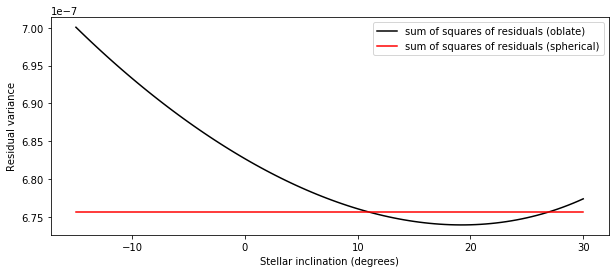

In [400]:
plt.figure(figsize=[10, 4])
plt.plot(np.linspace(-15,30,100),obl_resids,c='k',label='sum of squares of residuals (oblate)')
plt.plot(np.linspace(-15,30,100),sph_resids,c='r',label='sum of squares of residuals (spherical)')
plt.xlabel("Stellar inclination (degrees)")
plt.ylabel("Residual variance")
plt.legend()
plt.savefig('LeastSquares_stellarinc.png',dpi=500)